<span style="font-size: 40px;">HW4-3: Enhance DQN for random mode WITH Training Tips</span>

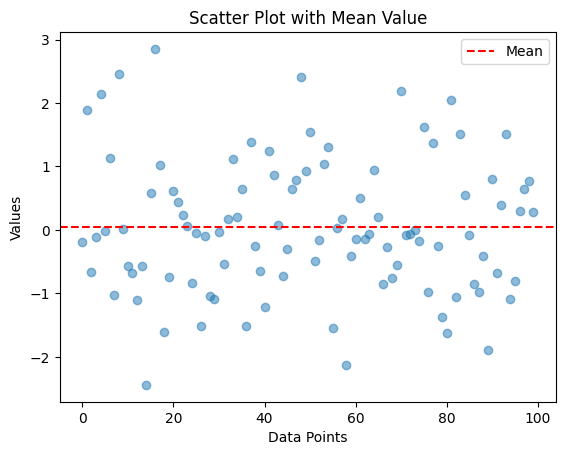

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = np.random.randn(100)

# Calculate the mean value
mean_value = np.mean(data)

# Plot the data with alpha level
plt.scatter(range(len(data)), data, alpha=0.5)

# Add a horizontal line for the mean value
plt.axhline(mean_value, color='red', linestyle='--', label='Mean')

# Set plot properties
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Scatter Plot with Mean Value')
plt.legend()

# Display the plot
plt.show()

In [3]:
from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [4]:
#使用GPU
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # 如果是 GPU 版應該會顯示 True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

2.7.0+cu118
True
Using device: cuda


In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

L1 = 64 #輸入層的寬度
L2 = 150 #第一隱藏層的寬度
L3 = 100 #第二隱藏層的寬度
L4 = 4 #輸出層的寬度

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層的shape 
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層的shape
).to(device)
loss_fn = torch.nn.MSELoss() #指定損失函數為MSE（均方誤差）
learning_rate = 1e-3  #設定學習率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #指定優化器為Adam，其中model.parameters會傳回所有要優化的權重參數

gamma = 0.9 #折扣因子
epsilon = 1.0

In [6]:
action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}

In [7]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode) #產生一場測試遊戲
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float().to(device)
    if display:
      print("Initial State:")
      print(test_game.display())
    status = 1
    while(status == 1): #遊戲仍在進行
      qval = model(state)
      qval_ = qval.cpu().data.numpy()
      action_ = np.argmax(qval_) 
      action = action_set[action_]
      if display:
        print('Move #: %s; Taking action: %s' % (i, action))
      test_game.makeMove(action)
      state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
      state = torch.from_numpy(state_).float().to(device)
      if display:
        print(test_game.display())
      reward = test_game.reward()
      if reward != -1: #代表勝利（抵達終點）或落敗（掉入陷阱）
        if reward > 0: #reward>0，代表成功抵達終點
          status = 2 #將狀態設為2，跳出迴圈
          if display:
            print("Game won! Reward: %s" %reward)
          else: #掉入陷阱
            status = 0 #將狀態設為0，跳出迴圈
            if display:
              print("Game LOST. Reward: %s" %reward)
      i += 1 #每移動一步，i就加1
      if (i > 10): #若移動了10步，仍未取出勝利，則一樣視為落敗
        if display:
          print("Game lost; too many moves.")
        break    
    win = True if status == 2 else False
    print(win)
    return win

<span style="font-size: 36px;">Double DQN for random mode(PyTorch Lightning) with training techniques</span>

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\tsai\Desktop\reinforcement_learning\pytorch_env\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory c:\Users\tsai\Desktop\reinforcement_learning\hw4\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | model        | QNet    | 8.8 K  | train
1 | target_model | QNet    | 8.8 K  | train
2 | loss_fn      | MSELoss | 0      | train
-------------------------------------------------
17.7 K    Trainable params
0         Non-trainable params
17.7 K    Total params
0.071     Total estimated model params size (MB)
7         Modules in train mode
0         

Epoch 999: 100%|██████████| 16/16 [00:00<00:00, 67.12it/s, loss_step=0.00182, loss_epoch=0.00179]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 16/16 [00:00<00:00, 64.17it/s, loss_step=0.00182, loss_epoch=0.00179]


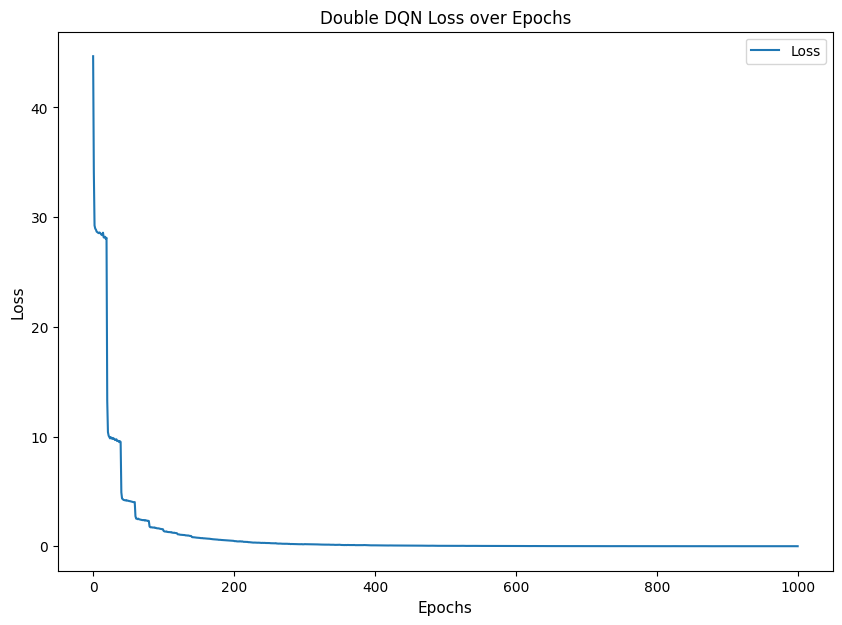

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback

# ==== 模擬 ReplayBuffer 和 Dataset（你可以替換為自己的） ====
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []

    def push(self, *transition):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return zip(*batch)

    def __len__(self):
        return len(self.buffer)

class ReplayDataset(Dataset):
    def __init__(self, buffer):
        self.buffer = buffer.buffer

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        state, action, reward, next_state, done = self.buffer[idx]
        return (
            torch.tensor(state, dtype=torch.float32),
            torch.tensor(action, dtype=torch.int64),
            torch.tensor(reward, dtype=torch.float32),
            torch.tensor(next_state, dtype=torch.float32),
            torch.tensor(done, dtype=torch.float32),
        )

# ==== Q-Network ====
class QNet(nn.Module):
    def __init__(self):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# ==== Double DQN Lightning 模型 ====
class DoubleDQNLightning(pl.LightningModule):
    def __init__(self, gamma=0.9, lr=1e-3):
        super().__init__()
        self.model = QNet()
        self.target_model = QNet()
        self.target_model.load_state_dict(self.model.state_dict())
        self.loss_fn = nn.MSELoss()
        self.gamma = gamma
        self.lr = lr
        self.sync_interval = 20
        self.automatic_optimization = True

    def training_step(self, batch, batch_idx):
        state, action, reward, next_state, done = batch

        q_values = self.model(state)
        q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

        # Double DQN 核心邏輯
        with torch.no_grad():
            next_actions = self.model(next_state).argmax(dim=1)
            next_q_values = self.target_model(next_state)
            next_q_value = next_q_values.gather(1, next_actions.unsqueeze(1)).squeeze(1)
            expected_q = reward + self.gamma * next_q_value * (1 - done)

        loss = self.loss_fn(q_value, expected_q)

        # 每 sync_interval 次更新 target model
        if self.current_epoch % self.sync_interval == 0 and batch_idx == 0:
            self.target_model.load_state_dict(self.model.state_dict())
            
        self.log("loss", loss, on_epoch=True, prog_bar=True)
        return loss
        # return {"loss": loss}

    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=self.lr)

# ==== 自定義 Callback 來紀錄 loss ====
class LossHistoryCallback(Callback):
    def __init__(self):
        self.losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        loss = trainer.callback_metrics.get("loss")
        if loss is not None:
            self.losses.append(loss.item())
            print(f"Epoch {trainer.current_epoch}, Loss: {loss.item():.4f}")

# ==== 模擬 buffer 並創建 DataLoader ====
buffer = ReplayBuffer(capacity=10000)

# 你這裡應該會有環境互動收集資料的程式，略去細節：
for _ in range(2000):
    state = np.random.rand(64)
    next_state = np.random.rand(64)
    action = np.random.randint(0, 4)
    reward = random.choice([-1, 10])
    done = float(reward != -1)
    buffer.push(state, action, reward, next_state, done)

dataset = ReplayDataset(buffer)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# ==== 訓練 ====
model = DoubleDQNLightning()
loss_callback = LossHistoryCallback()

trainer = pl.Trainer(
    max_epochs=1000,
    accelerator="gpu",  # 或 "auto"
    devices=1,
    callbacks=[loss_callback],
    logger=False  # 不用 tensorboard logger
)

trainer.fit(model, dataloader)

# ==== 繪製 Loss 圖 ====
plt.figure(figsize=(10, 7))
plt.plot(loss_callback.losses, label="Loss")
plt.xlabel("Epochs", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.title("Double DQN Loss over Epochs")
plt.legend()
plt.show()


<span style="font-size: 36px;">Dueling DQN for random mode(PyTorch Lightning) with training techniques</span>